# Speed and Alignment Notebook |
##### <strong>Author:</strong> <u>Walter Dych</u> <em>(walterpdych@gmail.com)</em>
##### <strong>Edits/Documentation:</strong> <u>Karee Garvin</u> <em>(kgarvin@fas.harvard.edu)</em>
This notebook focuses on calculating the speed of the right wrist and aligning it with pitch data.

### <strong>Load Data</strong>
In this section, the data is loaded into the notebook for further processing. You can adjust the source file paths as needed.

In [37]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

In [38]:
# Load keypoint data
keypoints_df = pd.read_pickle('C:/Users/cosmo/Desktop/Random Scripts/Co-Speech Gesture Automation/Co-Speech-Gesture-Automation/MOTION_TRACKING_FILES/5003_I_keypoints.pkl')

In [39]:
# Convert keypoints data to DataFrame
keypoints_df = pd.DataFrame(keypoints_df)
# Show keypoint data
keypoints_df

,time_ms,right_shoulder_x,right_shoulder_y,left_shoulder_x,left_shoulder_y,right_elbow_x,right_elbow_y,left_elbow_x,left_elbow_y,right_wrist_x,right_wrist_y,left_wrist_x,left_wrist_y,right_eye_x,right_eye_y,left_eye_x,left_eye_y,nose_x,nose_y
0,0.000000,0.199463,0.340649,0.307089,0.326427,0.209208,0.516104,0.317789,0.469892,0.309411,0.596308,0.333597,0.567451,0.261056,0.208618,0.284653,0.215582,0.278071,0.237287
1,33.366667,0.199205,0.340690,0.307200,0.324761,0.209811,0.517547,0.317766,0.469894,0.309902,0.598627,0.333460,0.570136,0.267084,0.210641,0.285232,0.215626,0.283179,0.236994
2,66.733333,0.198797,0.340773,0.307264,0.323920,0.210236,0.518136,0.317766,0.469977,0.310517,0.600213,0.333448,0.572002,0.269497,0.211850,0.285584,0.215714,0.285020,0.236878
3,100.100000,0.198196,0.341093,0.307282,0.323479,0.210782,0.518799,0.317788,0.470244,0.311279,0.601455,0.333448,0.573991,0.268893,0.213135,0.285734,0.216393,0.284711,0.237088
4,133.466667,0.197653,0.341525,0.307296,0.323301,0.211025,0.519491,0.317821,0.470756,0.311851,0.602099,0.333478,0.575677,0.268379,0.214034,0.285785,0.217125,0.284319,0.237508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27142,905638.066667,0.206125,0.338583,0.302290,0.322288,0.233486,0.508812,0.318644,0.467695,0.320299,0.606390,0.325333,0.594677,0.278026,0.216274,0.294548,0.216091,0.291911,0.234981
27143,905671.433333,0.206185,0.338427,0.302592,0.322326,0.233556,0.508712,0.318653,0.467706,0.320339,0.606360,0.325574,0.594616,0.278034,0.216282,0.294653,0.216103,0.291932,0.234917
27144,905704.800000,0.206348,0.337833,0.302903,0.322060,0.233571,0.507235,0.318699,0.466909,0.320347,0.605873,0.325613,0.594055,0.277924,0.216243,0.294691,0.215957,0.291850,0.234888
27145,905738.166667,0.206676,0.336745,0.303402,0.321701,0.233593,0.505657,0.318764,0.466658,0.320415,0.605315,0.325464,0.593937,0.277642,0.216103,0.294705,0.215690,0.291659,0.234785


### <strong>Choosing The Right Keypoints</strong>

Using this script, we can isolate the keypoints with which we would like to perform the analyses on. Below is the index of Keypoints defined in mediapipe:

<figure>
    <img src="https://developers.google.com/static/mediapipe/images/solutions/pose_landmarks_index.png" width=25% height=25%
         alt="Keypoint Index">
    <figcaption>Mediapipe Pose Keypoint Index</figcaption>
</figure>


Luckily, we have created a dictionary of the keypoints and can now refer to them by their name instead of the number its been asigned.

### <strong><u>Available Keypoints:</u></strong>
<table>
  <tr>
    <td>right_wrist</td>
    <td>left_wrist</td>
    <td>right_elbow</td>
    <td>left_elbow</td>
    <td>nose</td>
  </tr>
  <tr>
    <td>right_shoulder</td>
    <td>left_shoulder</td>
    <td>right_eye</td>
    <td>left_eye</td>
  </tr>
</table>


In [40]:
KEYPOINT = "right_wrist"

### <strong>Calculate Unsmoothed Speed</strong>
Here, the speed of the right wrist is calculated without any smoothing. Parameters such as the sampling rate can be adjusted.

In [41]:
# Calculate the unsmoothed speed of the right wrist
keypoints_df['delta_time'] = keypoints_df['time_ms'].diff()
keypoints_df['delta_x'] = keypoints_df[KEYPOINT + '_x'].diff()
keypoints_df['delta_y'] = keypoints_df[KEYPOINT + '_y'].diff()

# Speed = sqrt(delta_x^2 + delta_y^2) / delta_time
keypoints_df['speed_unsmooth'] = np.sqrt(keypoints_df['delta_x']**2 + keypoints_df['delta_y']**2) / (keypoints_df['delta_time'] / 1000)  # in unit/s

### <strong>Apply Savitzky-Golay Filtering</strong>
The Savitzky-Golay filtering method is applied to smooth the speed data. You can adjust the window size and polynomial order.

This code block is used to smooth the values in the `speed_unsmooth` column of a Pandas DataFrame called `keypoints_df`. The first line of code sets any values in the `speed_unsmooth` column that are below the 20th percentile to 0, effectively removing any low-speed outliers from the data. The second line of code applies a Savitzky-Golay filter to the `speed_unsmooth` column with a window size of 9 and a polynomial order of 2, and stores the smoothed values in a new column called `speed_smooth`.

The `np.percentile()` function is used to calculate the 20th percentile of the `speed_unsmooth` column, which is used as the threshold for removing low-speed outliers. The `savgol_filter()` function is used to apply a Savitzky-Golay filter to the `speed_unsmooth` column, which is a type of smoothing filter that can be used to remove noise from data while preserving important features such as peaks and valleys.

Overall, this code block is used to smooth the values in the `speed_unsmooth` column of a DataFrame using a Savitzky-Golay filter, and remove low-speed outliers from the data. Possible ways to improve the code include adding comments to explain the purpose of each line of code, and using more descriptive variable names.

In [42]:
keypoints_df['speed_smooth'] = [0 if x < np.percentile(keypoints_df['speed_unsmooth'], 20) else x for x in keypoints_df['speed_unsmooth']]
keypoints_df['speed_smooth'] = savgol_filter(keypoints_df['speed_unsmooth'], 11, 1)
keypoints_df

,time_ms,right_shoulder_x,right_shoulder_y,left_shoulder_x,left_shoulder_y,right_elbow_x,right_elbow_y,left_elbow_x,left_elbow_y,right_wrist_x,...,right_eye_y,left_eye_x,left_eye_y,nose_x,nose_y,delta_time,delta_x,delta_y,speed_unsmooth,speed_smooth
0,0.000000,0.199463,0.340649,0.307089,0.326427,0.209208,0.516104,0.317789,0.469892,0.309411,...,0.208618,0.284653,0.215582,0.278071,0.237287,NaN,NaN,NaN,NaN,NaN
1,33.366667,0.199205,0.340690,0.307200,0.324761,0.209811,0.517547,0.317766,0.469894,0.309902,...,0.210641,0.285232,0.215626,0.283179,0.236994,33.366667,0.000491,0.002319,0.071042,NaN
2,66.733333,0.198797,0.340773,0.307264,0.323920,0.210236,0.518136,0.317766,0.469977,0.310517,...,0.211850,0.285584,0.215714,0.285020,0.236878,33.366667,0.000615,0.001586,0.050988,NaN
3,100.100000,0.198196,0.341093,0.307282,0.323479,0.210782,0.518799,0.317788,0.470244,0.311279,...,0.213135,0.285734,0.216393,0.284711,0.237088,33.366667,0.000762,0.001242,0.043666,NaN
4,133.466667,0.197653,0.341525,0.307296,0.323301,0.211025,0.519491,0.317821,0.470756,0.311851,...,0.214034,0.285785,0.217125,0.284319,0.237508,33.366667,0.000573,0.000644,0.025830,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27142,905638.066667,0.206125,0.338583,0.302290,0.322288,0.233486,0.508812,0.318644,0.467695,0.320299,...,0.216274,0.294548,0.216091,0.291911,0.234981,33.366667,0.000012,-0.000005,0.000397,0.005788
27143,905671.433333,0.206185,0.338427,0.302592,0.322326,0.233556,0.508712,0.318653,0.467706,0.320339,...,0.216282,0.294653,0.216103,0.291932,0.234917,33.366667,0.000040,-0.000031,0.001512,0.006682
27144,905704.800000,0.206348,0.337833,0.302903,0.322060,0.233571,0.507235,0.318699,0.466909,0.320347,...,0.216243,0.294691,0.215957,0.291850,0.234888,33.366667,0.000007,-0.000486,0.014575,0.007577
27145,905738.166667,0.206676,0.336745,0.303402,0.321701,0.233593,0.505657,0.318764,0.466658,0.320415,...,0.216103,0.294705,0.215690,0.291659,0.234785,33.366667,0.000068,-0.000558,0.016854,0.008472


### <strong>Align Speed Data with Pitch Data</strong>
This section aligns the calculated speed data with the pitch data. Any time offsets or scaling factors can be adjusted here.

In [43]:
# Upsample the speed data to match the 10 ms sample rate of the pitch data
keypoints_df['time_ms'] = pd.to_timedelta(keypoints_df['time_ms'], unit='ms')
keypoints_df = keypoints_df.set_index('time_ms')
keypoints_df_upsampled = keypoints_df.resample('10ms').mean().interpolate(method='linear')

# Convert the datetime index to integer format
keypoints_df_upsampled.index = (keypoints_df_upsampled.index - keypoints_df_upsampled.index[0]).total_seconds() * 1000

# Merge the upsampled speed data with the pitch data
aligned_df = keypoints_df_upsampled

# Drop unnecessary columns
aligned_df = aligned_df.drop(columns=['delta_time', 'delta_x', 'delta_y'])

### <strong>Save Aligned Data as CSV</strong>
Finally, the aligned data is saved as a CSV file. You can specify the destination path for the output file.

In [44]:
# Save the aligned data as a CSV file
aligned_df['time_ms'] = pd.to_numeric(aligned_df.index)
aligned_df.to_csv(f'C:/Users/cosmo/Desktop/Random Scripts/Co-Speech Gesture Automation/Co-Speech-Gesture-Automation/SPEED_FILES/5003_I_'+ KEYPOINT + '_processed_data.csv', index=False)
aligned_df.head()

,right_shoulder_x,right_shoulder_y,left_shoulder_x,left_shoulder_y,right_elbow_x,right_elbow_y,left_elbow_x,left_elbow_y,right_wrist_x,right_wrist_y,...,left_wrist_y,right_eye_x,right_eye_y,left_eye_x,left_eye_y,nose_x,nose_y,speed_unsmooth,speed_smooth,time_ms
time_ms,,,,,,,,,,,,,,,,,,,,,
0.0,0.199463,0.340649,0.307089,0.326427,0.209208,0.516104,0.317789,0.469892,0.309411,0.596308,...,0.567451,0.261056,0.208618,0.284653,0.215582,0.278071,0.237287,NaN,NaN,0.0
10.0,0.199377,0.340663,0.307126,0.325872,0.209409,0.516585,0.317781,0.469893,0.309574,0.597081,...,0.568346,0.263065,0.209292,0.284846,0.215597,0.279773,0.237189,NaN,NaN,10.0
20.0,0.199291,0.340676,0.307163,0.325316,0.209610,0.517066,0.317773,0.469894,0.309738,0.597854,...,0.569241,0.265075,0.209966,0.285039,0.215611,0.281476,0.237091,NaN,NaN,20.0
30.0,0.199205,0.340690,0.307200,0.324761,0.209811,0.517547,0.317766,0.469894,0.309902,0.598627,...,0.570136,0.267084,0.210641,0.285232,0.215626,0.283179,0.236994,0.071042,NaN,30.0
40.0,0.199069,0.340718,0.307221,0.324481,0.209953,0.517743,0.317766,0.469922,0.310107,0.599156,...,0.570758,0.267888,0.211044,0.285349,0.215656,0.283793,0.236955,0.064357,NaN,40.0


### <strong>Plot Data</strong>


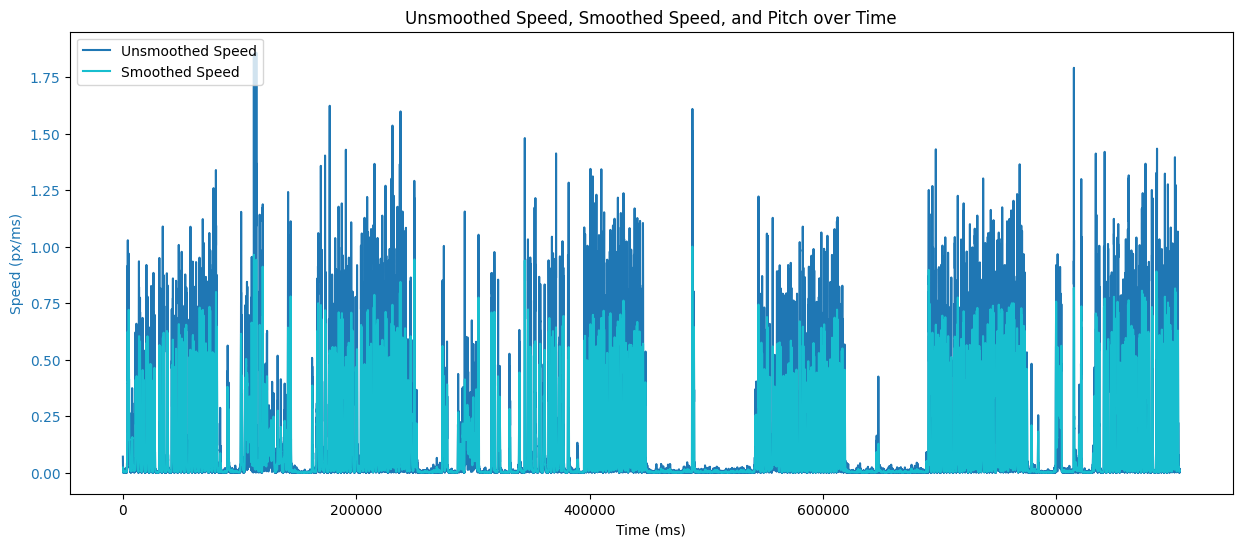

In [45]:
# Create a plot
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot unsmoothed and smoothed speed
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Speed (px/ms)', color='tab:blue')
ax1.plot(aligned_df['time_ms'], aligned_df['speed_unsmooth'], label='Unsmoothed Speed', color='tab:blue')
ax1.plot(aligned_df['time_ms'], aligned_df['speed_smooth'], label='Smoothed Speed', color='tab:cyan')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Add title and legend
plt.title('Unsmoothed Speed, Smoothed Speed, and Pitch over Time')
ax1.legend(loc='upper left')

plt.show()